Wii-PS3間プラットフォーム競争計算機実験のための初期設定

In [1]:
using DifferentialEquations
#
sides = [:user, :cmpl]
#
TIMESTEP = 0.015625
TIMEMAX = 109
#
ComplementorsSwitchFlag=0
#
AdvertisingEndTimeA = 72
AdvertisingEndTimeB = 87
AdvertisingStartTimeA = 1
AdvertisingStartTimeB = 0
ComplementsAVelocity = Dict(:user => 0.4003, :cmpl => 0.1556)
ComplementsBVelocity = Dict(:user => 0.1381, :cmpl => 0.2204)
DepletionRateA = 0.01
DepletionRateB = 0.01
IndirectNetworkEffectsStrengthA = 0.1394  # 感度分析のためにパラメータ設定する
IndirectNetworkEffectsStrengthB = 0.253   # 感度分析のためにパラメータ設定する
InitialQualityA = 1
InitialQualityB = 1
ReferenceExpectationA = 6033.13
ReferenceExpectationB = 51.9356
ResponseTimeA = Dict(:user => 29.8852, :cmpl => 46.7199)
ResponseTimeB = Dict(:user => 4, :cmpl => 16.6598)
SalesVolumeAperUser = 2
SalesVolumeBperUser = 0.9
SubstituteValueA = Dict(:user => 1, :cmpl => 1e+07)
SubstituteValueB = Dict(:user => 45550.8, :cmpl => 3.0222e+061)
#
TotalPopulation = Dict(:user => 2.30476e+07, :cmpl => 115)
#
AdvertisingEffectivenessA = Dict(:user => 0.0001, :cmpl => 0.0153)
AdvertisingEffectivenessB = Dict(:user => 0.0039, :cmpl => 0.0119)
ContactRateA = Dict(:user => 0.9905, :cmpl => 1e-05)
ContactRateB = Dict(:user => 1e-05, :cmpl => 0.3547)
ExitRateA = Dict(:user => 0.5, :cmpl => 0.006)
ExitRateB = Dict(:user => 0.2481, :cmpl => 0.0)
ReferenceComplementVolumeA = Dict(:user => 6.68753e+07, :cmpl => 464)
ReferenceComplementVolumeB = Dict(:user => 7.40713e+07, :cmpl => 943)

Dict{Symbol, Real} with 2 entries:
  :user => 7.40713e7
  :cmpl => 943

モデルの定義

In [2]:

function systemdynamics!(dY, Y, p, t)

IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB = p
#
    # zidz function moved inside systemdynamics!

      function zidz(a, b)
          if abs(b) < 1e-6
              return 0.0
          else
              return a / b
          end
      end

 # Assign variables from Y
 AccumulatedAdoptersA = Dict(:user => Y[1], :cmpl => Y[2])
 AccumulatedAdoptersB = Dict(:user => Y[3], :cmpl => Y[4])
 ComplementsASalesVolume = Dict(:user => Y[5], :cmpl => Y[6])
 ComplementsBSalesVolume = Dict(:user => Y[7], :cmpl => Y[8])
 ExpectedQualityA = Y[9]
 ExpectedQualityB = Y[10]
 MultihomingUsers = Dict(:user => Y[11], :cmpl => Y[12])
 PlatformAAdopters = Dict(:user => Y[13], :cmpl => Y[14])
 PlatformBAdopters = Dict(:user => Y[15], :cmpl => Y[16])
 PlatformASalesVolume = Y[17]
 PlatformBSalesVolume = Y[18]
 PotentialAdopters = Dict(:user => Y[19], :cmpl => Y[20])

# Implement the equations
# Initialize dictionaries for variables that vary by side
sides = [:user, :cmpl]
flip(s) = s == :user ? :cmpl : :user

AdvertisingEffectsA = Dict(s => ifelse((t >= AdvertisingStartTimeA) && (t < AdvertisingEndTimeA), AdvertisingEffectivenessA[s]*PotentialAdopters[s], 0) for s in sides)
AdvertisingEffectsB = Dict(s => ifelse((t >= AdvertisingStartTimeB) && (t < AdvertisingEndTimeB), AdvertisingEffectivenessB[s]*PotentialAdopters[s], 0) for s in sides)

PlatformAAdopterFraction = Dict(s => PlatformAAdopters[s] / TotalPopulation[s] for s in sides)
PlatformBAdopterFraction = Dict(s => PlatformBAdopters[s] / TotalPopulation[s] for s in sides)

ComplementsASalesIncrement = Dict(s => PlatformAAdopters[s] * ComplementsAVelocity[s] for s in sides)
ComplementsBSalesIncrement = Dict(s => PlatformBAdopters[s] * ComplementsBVelocity[s] for s in sides)
ComplementValuetoPlatformA = Dict(s => ComplementsASalesVolume[s] / ReferenceComplementVolumeA[s] for s in sides)
ComplementValuetoPlatformB = Dict(s => ComplementsBSalesVolume[s] / ReferenceComplementVolumeB[s] for s in sides)

AdoptersExpectationA = PlatformAAdopters[:user] / ReferenceExpectationA
AdoptersExpectationB = PlatformBAdopters[:user] / ReferenceExpectationB
ExpectedIncrementA = AdoptersExpectationA
ExpectedIncrementB = AdoptersExpectationB
ExpectedQualityDepletionA = if t >= AdvertisingEndTimeA
    ExpectedQualityA * DepletionRateA
else
    0
end 
ExpectedQualityDepletionB = if t >= AdvertisingEndTimeB
    ExpectedQualityB * DepletionRateB
else
    0
end 

ValuetoNonPlatformAAdopters = Dict(s => ExpectedQualityA*ComplementValuetoPlatformA[flip(s)]*(PlatformAAdopterFraction[flip(s)])^IndirectNetworkEffectsStrengthA for s in sides)
ValuetoNonPlatformBAdopters = Dict(s => ExpectedQualityB*ComplementValuetoPlatformB[flip(s)]*(PlatformBAdopterFraction[flip(s)])^IndirectNetworkEffectsStrengthB for s in sides)

AdoptionFractionA = Dict(s => zidz(ValuetoNonPlatformAAdopters[s], ValuetoNonPlatformAAdopters[s] + ValuetoNonPlatformBAdopters[s] + SubstituteValueA[s]) for s in sides)
AdoptionFractionB = Dict(s => zidz(ValuetoNonPlatformBAdopters[s], ValuetoNonPlatformAAdopters[s] + ValuetoNonPlatformBAdopters[s] + SubstituteValueB[s]) for s in sides)

PlatformAValuetoPlatformAAdopters = Dict(s => ValuetoNonPlatformAAdopters[s] for s in sides)
PlatformAValuetoPlatformBAdopters = Dict(s => ValuetoNonPlatformAAdopters[s] for s in sides)
PlatformBValuetoPlatformAAdopters = Dict(s => ValuetoNonPlatformBAdopters[s] for s in sides)
PlatformBValuetoPlatformBAdopters = Dict(s => ValuetoNonPlatformBAdopters[s] for s in sides)

CombinedValuetoPlatformAAdopters = Dict(s => PlatformAValuetoPlatformAAdopters[s] + PlatformBValuetoPlatformAAdopters[s] for s in sides)
CombinedValuetoPlatformBAdopters = Dict(s => PlatformBValuetoPlatformBAdopters[s] + PlatformAValuetoPlatformBAdopters[s] for s in sides)

SwitchFractiontoA = Dict(s => zidz(PlatformAValuetoPlatformBAdopters[s], CombinedValuetoPlatformBAdopters[s] + SubstituteValueB[s]) for s in sides)
SwitchFractiontoB = Dict(s => zidz(PlatformBValuetoPlatformAAdopters[s], CombinedValuetoPlatformAAdopters[s] + SubstituteValueA[s]) for s in sides)
IndicatedSwitcherstoA = Dict(s => SwitchFractiontoA[s] * PlatformBAdopters[s] / ResponseTimeB[s] for s in sides)
IndicatedSwitcherstoB = Dict(s => SwitchFractiontoB[s] * PlatformAAdopters[s] / ResponseTimeA[s] for s in sides)

SwitchersfromAtoB = Dict(s => s==:user ? IndicatedSwitcherstoB[s] : IndicatedSwitcherstoB[s]*ComplementorsSwitchFlag for s in sides)
SwitchersfromBtoA = Dict(s => s==:user ? IndicatedSwitcherstoA[s] : IndicatedSwitcherstoA[s]*ComplementorsSwitchFlag for s in sides)
SwitcherstoA = SwitchersfromBtoA
SwitcherstoB = SwitchersfromAtoB

WordofMouthEffectsA = Dict(s => zidz(ContactRateA[s] * AdoptionFractionA[s] * PlatformAAdopters[s] * PotentialAdopters[s], TotalPopulation[s]) for s in sides)
WordofMouthEffectsB = Dict(s => zidz(ContactRateB[s] * AdoptionFractionB[s] * PlatformBAdopters[s] * PotentialAdopters[s], TotalPopulation[s]) for s in sides)

NewAdoptersA = Dict(s => min(PotentialAdopters[s]/TIMESTEP, AdvertisingEffectsA[s] + WordofMouthEffectsA[s]) for s in sides)
NewAdoptersB = Dict(s => min(PotentialAdopters[s]/TIMESTEP, AdvertisingEffectsB[s] + WordofMouthEffectsB[s]) for s in sides)

AdoptersAIncrement = Dict(s => NewAdoptersA[s] + SwitcherstoA[s] for s in sides)
AdoptersBIncrement = Dict(s => NewAdoptersB[s] + SwitcherstoB[s] for s in sides)

PlatformASalesIncrement = AdoptersAIncrement[:user]*SalesVolumeAperUser
PlatformBSalesIncrement = AdoptersBIncrement[:user]*SalesVolumeBperUser

PlatformAExit = Dict(s => ifelse(t >= AdvertisingEndTimeA, PlatformAAdopters[s]*ExitRateA[s], 0) for s in sides)
PlatformBExit = Dict(s => ifelse(t >= AdvertisingEndTimeB, PlatformBAdopters[s]*ExitRateB[s], 0) for s in sides)

MultihomingIncrement = Dict(s => SwitcherstoA[s] + SwitcherstoB[s] for s in sides)
MultihomingRatio = Dict(s => zidz(MultihomingUsers[s], (AccumulatedAdoptersA[s] + AccumulatedAdoptersB[s])) for s in sides)

TotalDiffusionRate = Dict(s => (PlatformAAdopters[s] + PlatformBAdopters[s]) / TotalPopulation[s] for s in sides)

#
# Update dY
#
dY[1] =  AdoptersAIncrement[:user]
dY[2] =  AdoptersAIncrement[:cmpl]
dY[3] =  AdoptersBIncrement[:user]
dY[4] =  AdoptersBIncrement[:cmpl]
dY[5] =  ComplementsASalesIncrement[:user]
dY[6] =  ComplementsASalesIncrement[:cmpl]
dY[7] =  ComplementsBSalesIncrement[:user]
dY[8] =  ComplementsBSalesIncrement[:cmpl]
dY[9] =  ExpectedIncrementA-ExpectedQualityDepletionA
dY[10] =  ExpectedIncrementB-ExpectedQualityDepletionB
dY[11] =  MultihomingIncrement[:user]
dY[12] =  MultihomingIncrement[:cmpl]
dY[13] = NewAdoptersA[:user]+SwitcherstoA[:user]-SwitcherstoB[:user]-PlatformAExit[:user]
dY[14] = NewAdoptersA[:cmpl]+SwitcherstoA[:cmpl]-SwitcherstoB[:cmpl]-PlatformAExit[:cmpl]
dY[15] = SwitcherstoB[:user]+NewAdoptersB[:user]-SwitcherstoA[:user]-PlatformBExit[:user]
dY[16] = SwitcherstoB[:cmpl]+NewAdoptersB[:cmpl]-SwitcherstoA[:cmpl]-PlatformBExit[:cmpl]
dY[17] =  PlatformASalesIncrement
dY[18] =  PlatformBSalesIncrement
dY[19] =  -NewAdoptersA[:user]-NewAdoptersB[:user]
dY[20] =  -NewAdoptersA[:cmpl]-NewAdoptersB[:cmpl]
#
end

systemdynamics! (generic function with 1 method)

時間積分のための初期値と時間範囲の設定
計算時間：50x50= Minutes.


In [3]:
# Initial conditions
Y0 = [
    919642, 11,         # AccumulatedAdoptersA
    187836, 5,             # AccumulatedAdoptersB
    1.85346e06, 21,      # ComplementsASalesVolume
    107347, 7,             # ComplementsBSalesVolume
    InitialQualityA, InitialQualityB ,   # ExpectedQualityA, ExpectedQualityB
    0, 0,                         # MultihomingUsers
    919642, 11,        # PlatformAAdopters
    187836, 5,             # PlatformBAdopters
    919642, 187836,  # PlatformASalesVolume, PlatformBSalesVolume
    21940122,  99    # PotentialAdopters
]

# Time span
tspan = (0.0, TIMEMAX)

# Solve the ODE problem for different values of Indirect Network Effects Strength
IndirectNetworkEffectsStrengthA_values = range(0.01, stop=3.0, length=50)
IndirectNetworkEffectsStrengthB_values = range(0.01, stop=3.0, length=50)
#IndirectNetworkEffectsStrengthA_values = range(0.01, stop=2.0, length=40)
#IndirectNetworkEffectsStrengthB_values = range(0.01, stop=2.0, length=40)
#IndirectNetworkEffectsStrengthA_values = range(0.1, stop=2.0, length=20)
#IndirectNetworkEffectsStrengthB_values = range(0.1, stop=2.0, length=20)

# zidz function 
function zidz(a, b)
    if abs(b) < 1e-6
        return 0.0
    else
        return a / b
    end
end

results = []

for IndirectNetworkEffectsStrengthA in IndirectNetworkEffectsStrengthA_values
    for IndirectNetworkEffectsStrengthB in IndirectNetworkEffectsStrengthB_values
        #
        params = [IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB]
        prob = ODEProblem(systemdynamics!, Y0, tspan, params)
        sol = solve(prob, Euler(), dt=TIMESTEP) 
        #sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

         # Extract the values of AccumulatedAdoptersA, B at t = TIMEMAX
        aAdoptersA_user_TMAX = sol.u[end][1]
        aAdoptersA_cmpl_TMAX = sol.u[end][2]
        aAdoptersB_user_TMAX = sol.u[end][3]
        aAdoptersB_cmpl_TMAX = sol.u[end][4]

        # Extract the values of MultihomingRatio for users and complementors at t = TIMEMAX
        mhg_user_TMAX = sol.u[end][11]
        mhg_cmpl_TMAX = sol.u[end][12]
        mhg_ratios_user_TMAX = zidz(sol.u[end][11], (sol.u[end][1] + sol.u[end][3])) 
        mhg_ratios_cmpl_TMAX = zidz(sol.u[end][12], (sol.u[end][2] + sol.u[end][4])) 

       # Print the results
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, mhg_ratios_user_TMAX: $mhg_ratios_user_TMAX, mhg_ratios_cmpl_TMAX: $mhg_ratios_cmpl_TMAX")
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, aAdoptersA_user_TMAX : $aAdoptersA_user_TMAX, aAdoptersA_cmpl_TMAX : $aAdoptersA_cmpl_TMAX")
        #println("nwa: $IndirectNetworkEffectsStrengthA, nwb: $IndirectNetworkEffectsStrengthB, aAdoptersB_user_TMAX : $aAdoptersB_user_TMAX, aAdoptersB_cmpl_TMAX : $aAdoptersB_cmpl_TMAX")


        # Store the results
        push!(results, (IndirectNetworkEffectsStrengthA, IndirectNetworkEffectsStrengthB, 
        aAdoptersA_user_TMAX, aAdoptersA_cmpl_TMAX, aAdoptersB_user_TMAX, aAdoptersB_cmpl_TMAX,
        mhg_user_TMAX, mhg_cmpl_TMAX,
        mhg_ratios_user_TMAX, mhg_ratios_cmpl_TMAX))
    end
end


次のパッケージを事前にインストールすることが必要となる。JuliaのREPLを用いる（その方が早い）
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")

mhg_ratios_user_TMAX の最大値と最小値と、その値に対応するIndirectNetworkEffectsStrengthA、IndirectNetworkEffectsStrengthBの値を画面に表示し、外部ファイルにも記録する．

In [4]:
using CSV, DataFrames

# In addition to the previous code block

# Initialize min, max values and their corresponding parameters
min_mhg_ratios_user_TMAX = Inf
max_mhg_ratios_user_TMAX = -Inf
min_params = (0.0, 0.0)
max_params = (0.0, 0.0)

# Process results and find min/max values
for res in results
    if res[9] < min_mhg_ratios_user_TMAX
        min_mhg_ratios_user_TMAX = res[9]
        min_params = (res[1], res[2])
    end
    if res[9] > max_mhg_ratios_user_TMAX
        max_mhg_ratios_user_TMAX = res[9]
        max_params = (res[1], res[2])
    end
end

# Print min/max values and corresponding parameters
println("Min mhg_ratios_user_TMAX: $min_mhg_ratios_user_TMAX, 
         IndirectNetworkEffectsStrengthA: $(min_params[1]), 
         IndirectNetworkEffectsStrengthB: $(min_params[2])")
println("Max mhg_ratios_user_TMAX: $max_mhg_ratios_user_TMAX, 
         IndirectNetworkEffectsStrengthA: $(max_params[1]), 
         IndirectNetworkEffectsStrengthB: $(max_params[2])")

# Convert results to DataFrame
df = DataFrame(IndirectNetworkEffectsStrengthA = [res[1] for res in results], 
               IndirectNetworkEffectsStrengthB = [res[2] for res in results], 
               aAdoptersA_user_TMAX = [res[3] for res in results], 
               aAdoptersA_cmpl_TMAX = [res[4] for res in results], 
               aAdoptersB_user_TMAX = [res[5] for res in results], 
               aAdoptersB_cmpl_TMAX = [res[6] for res in results], 
               mhg_user_TMAX = [res[7] for res in results], 
               mhg_cmpl_TMAX = [res[8] for res in results], 
               mhg_ratios_user_TMAX = [res[9] for res in results], 
               mhg_ratios_cmpl_TMAX = [res[10] for res in results])

# Write results to CSV file
CSV.write("resultsWiPS3_3.csv", df)

# Write min/max values and their parameters to CSV file
min_max_df = DataFrame(min_mhg_ratios_user_TMAX = [min_mhg_ratios_user_TMAX], 
                       IndirectNetworkEffectsStrengthA_min = [min_params[1]], 
                       IndirectNetworkEffectsStrengthB_min = [min_params[2]], 
                       max_mhg_ratios_user_TMAX = [max_mhg_ratios_user_TMAX], 
                       IndirectNetworkEffectsStrengthA_max = [max_params[1]], 
                       IndirectNetworkEffectsStrengthB_max = [max_params[2]])
CSV.write("min_max_resultsWiiPS3_3.csv", min_max_df)



Min mhg_ratios_user_TMAX: 0.10525514109190004, 
         IndirectNetworkEffectsStrengthA: 0.01, 
         IndirectNetworkEffectsStrengthB: 3.0
Max mhg_ratios_user_TMAX: 0.6598003123093105, 
         IndirectNetworkEffectsStrengthA: 0.01, 
         IndirectNetworkEffectsStrengthB: 0.9863265306122448


"min_max_resultsWiiPS3_3.csv"

外部ファイルを作成せずに、等高線図を出力する

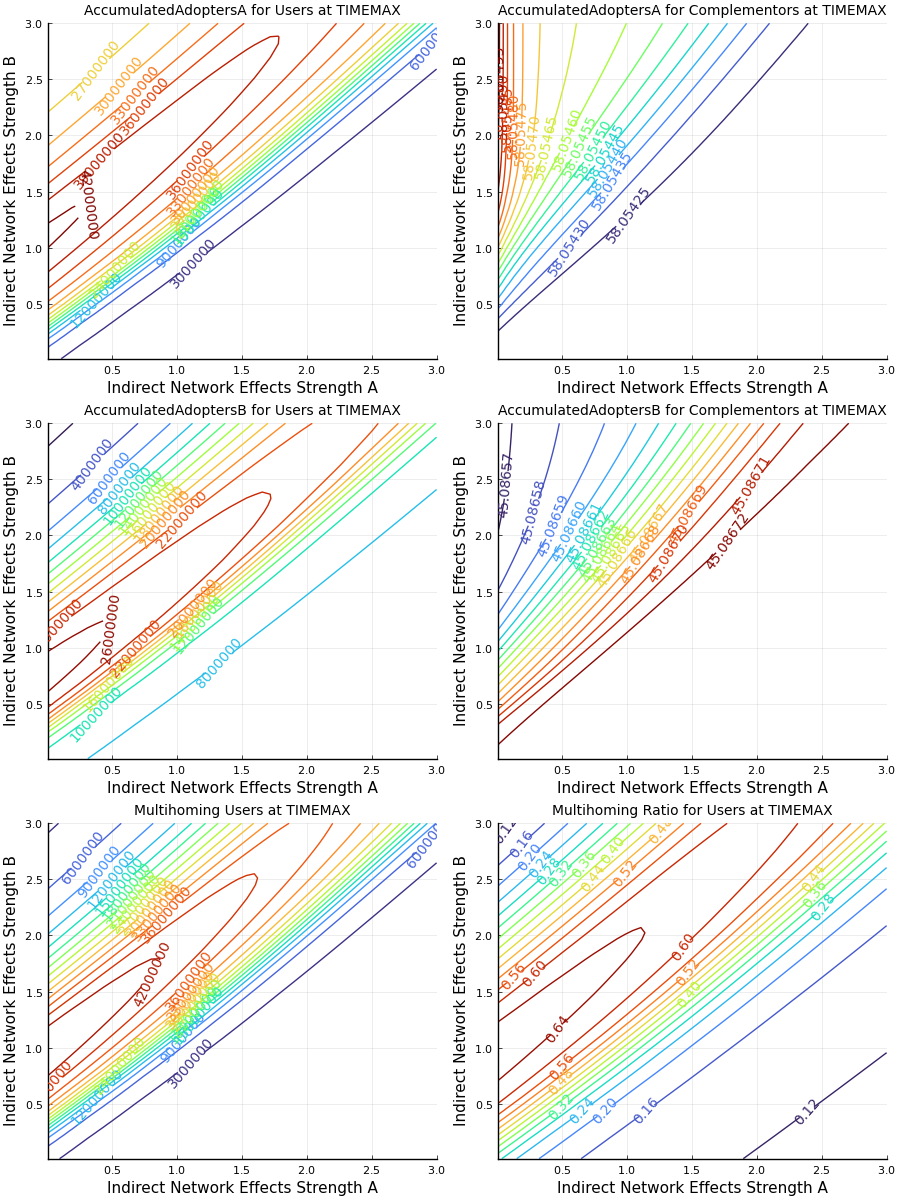

In [6]:
using Plots; pythonplot()
using LaTeXStrings

# Define the values for the contour plot
xvals = [r[1] for r in results]
yvals = [r[2] for r in results]
zvals1 = [r[3] for r in results]
zvals2 = [r[4] for r in results]
zvals3 = [r[5] for r in results]
zvals4 = [r[6] for r in results]
zvals5 = [r[7] for r in results]
zvals6 = [r[8] for r in results]
zvals7 = [r[9] for r in results]
zvals8 = [r[10] for r in results]

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
yvals_mtrx = reshape(yvals, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals1_mtrx = reshape(zvals1, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals2_mtrx = reshape(zvals2, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals3_mtrx = reshape(zvals3, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals4_mtrx = reshape(zvals4, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals5_mtrx = reshape(zvals5, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals6_mtrx = reshape(zvals6, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals7_mtrx = reshape(zvals7, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))
zvals8_mtrx = reshape(zvals8, length(IndirectNetworkEffectsStrengthA_values), length(IndirectNetworkEffectsStrengthB_values))

# Create the contour plots
p1 = contour(xvals_mtrx, yvals_mtrx, zvals1_mtrx, title="AccumulatedAdoptersA for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p2 = contour(xvals_mtrx, yvals_mtrx, zvals2_mtrx, title="AccumulatedAdoptersA for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p3 = contour(xvals_mtrx, yvals_mtrx, zvals3_mtrx, title="AccumulatedAdoptersB for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p4 = contour(xvals_mtrx, yvals_mtrx, zvals4_mtrx, title="AccumulatedAdoptersB for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p5 = contour(xvals_mtrx, yvals_mtrx, zvals5_mtrx, title="Multihoming Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)
p6 = contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10)

# Display the plot with larger size
display(plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200)))

6種類の等高線図をまとめて、外部ファイル出力する

In [8]:
using Plots
plot()

# Create the combined plot
p = plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200))

# Save the contour plot to a PNG file
savefig(p, "contourWiiPS3.png")

# Save the contour plot to a PDF file
savefig(p, "contourWiiPS3.pdf")

# Save the contour plot to a EPS file
savefig(p, "contourWiiPS3.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


"d:\\Dropbox\\JuliaDocs\\2_Wii_PS3_Case\\contourWiiPS3.eps"

総天然色等高線図を出力する

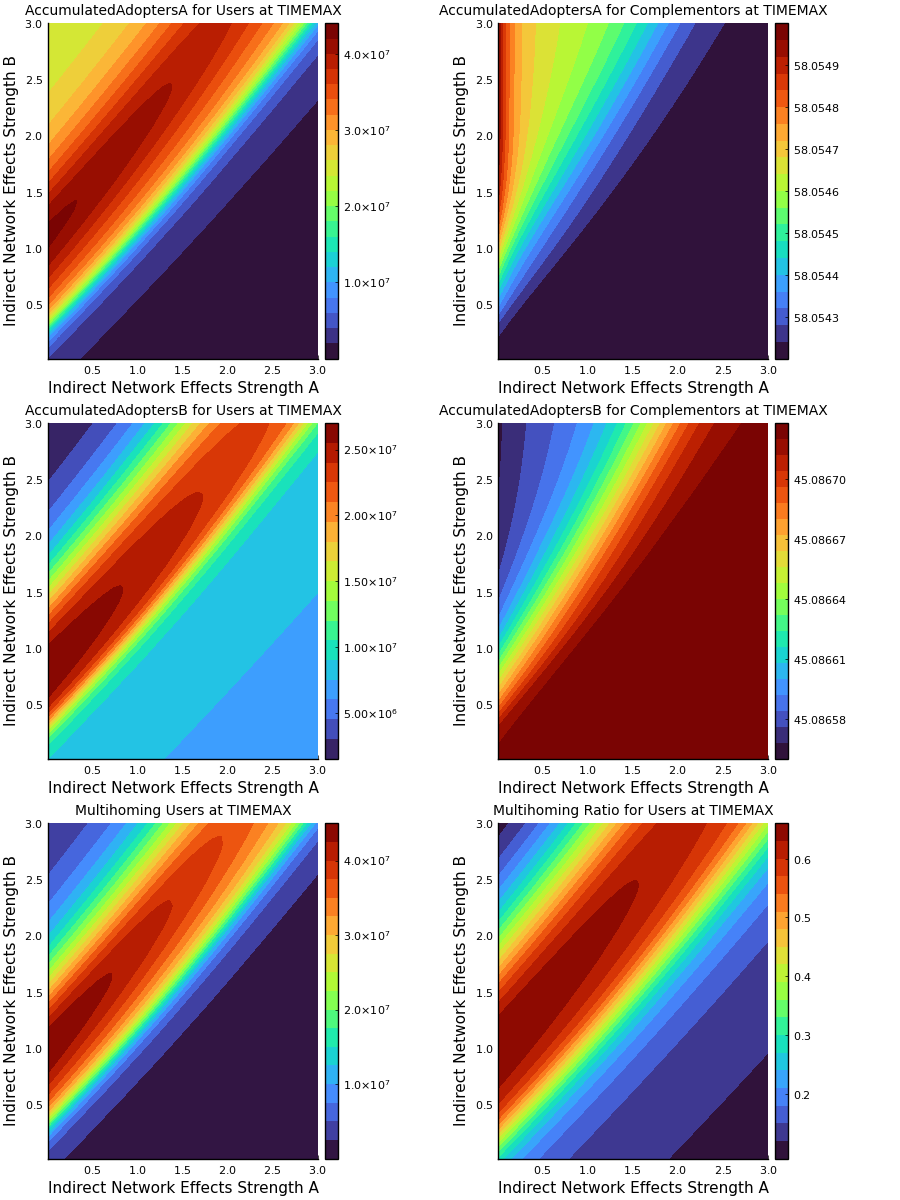

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [9]:
using Plots
plot()

# Create the contour plots
p1 = contourf(xvals_mtrx, yvals_mtrx, zvals1_mtrx, title="AccumulatedAdoptersA for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)
p2 = contourf(xvals_mtrx, yvals_mtrx, zvals2_mtrx, title="AccumulatedAdoptersA for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)
p3 = contourf(xvals_mtrx, yvals_mtrx, zvals3_mtrx, title="AccumulatedAdoptersB for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)
p4 = contourf(xvals_mtrx, yvals_mtrx, zvals4_mtrx, title="AccumulatedAdoptersB for Complementors at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)
p5 = contourf(xvals_mtrx, yvals_mtrx, zvals5_mtrx, title="Multihoming Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)
p6 = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10)

# Display the plot with larger size
display(plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200)))

総天然色等高線図をファイル出力する

In [10]:
using Plots
plot()

# Create the combined plot
p = plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), legend = false, size = (900, 1200))

# Save the contour plot to a PNG file
savefig(p, "fullcontourWiiPS3.png")

# Save the contour plot to a PDF file
savefig(p, "fullcontourWiiPS3.pdf")

# Save the contour plot to a EPS file
savefig(p, "fullcontourWiiPS3.eps")

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


"d:\\Dropbox\\JuliaDocs\\2_Wii_PS3_Case\\fullcontourWiiPS3.eps"

マルチホーミング率の等高線図のみを描画する

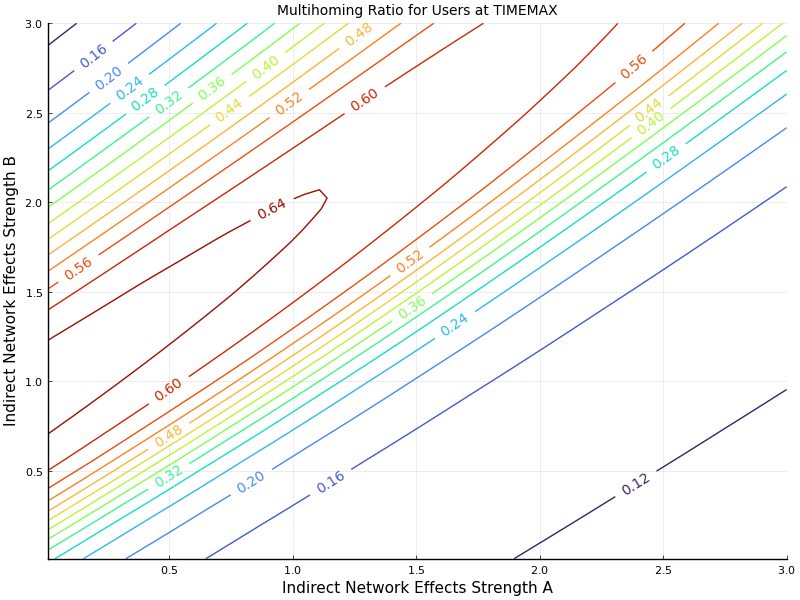

In [11]:
using Plots
plot()

contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10, size = (800, 600))

マルチホーミング率の等高線図をファイル出力する

In [12]:
using Plots
plot()

p = contour(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=15, color=:turbo, clabels=true, cbar=false, lw=1, titlefontsize=10, size = (800, 600))

# Save the contour plot to a PNG file
savefig(p, "contourMHGratioWiiPS3_3.png")

# Save the contour plot to a PDF file
savefig(p, "contourMHGratioWiiPS3_3.pdf")

# Save the contour plot to a EPS file
savefig(p, "contourMHGratioWiiPS3_3.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


"d:\\Dropbox\\JuliaDocs\\2_Wii_PS3_Case\\contourMHGratioWiiPS3_3.eps"

マルチホーミング率の総天然色等高線図のみを描画する

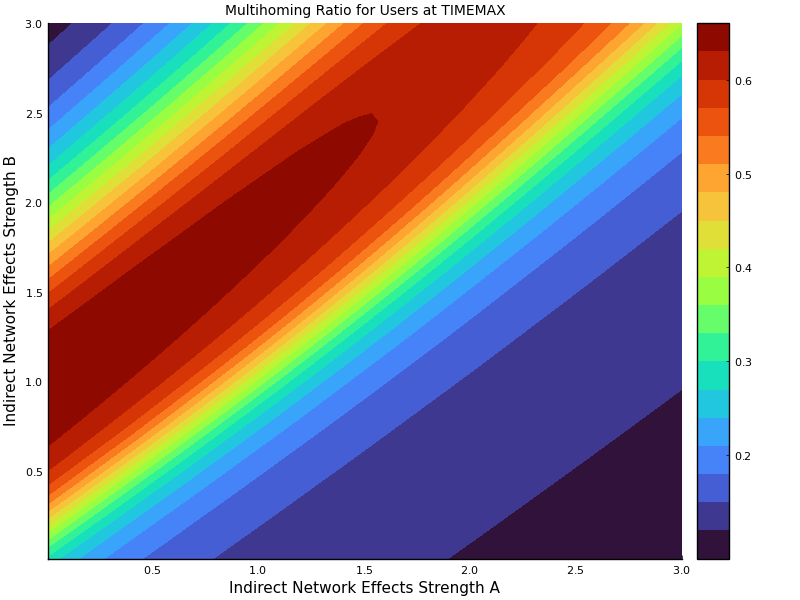

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
using Plots
plot()

contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10, size = (800, 600))

マルチホーミング率の総天然色等高線図のみを外部出力する

In [14]:
using Plots
plot()

p = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="Multihoming Ratio for Users at TIMEMAX", xlabel="Indirect Network Effects Strength A", ylabel="Indirect Network Effects Strength B", levels=20, color=:turbo, titlefontsize=10, size = (800, 600))

# Save the contour plot to a PNG file
savefig(p, "fullcontourMHGratioWiiPS3.png")

# Save the contour plot to a PDF file
savefig(p, "fullcontourMHGratioWiiPS3.pdf")

# Save the contour plot to a EPS file
savefig(p, "fullcontourMHGratioWiiPS3.eps")


sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


"d:\\Dropbox\\JuliaDocs\\2_Wii_PS3_Case\\fullcontourMHGratioWiiPS3.eps"